In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
import matplotlib as mpl
from jupyterthemes import jtplot #These two lines can be skipped if you are not using jupyter themes
jtplot.reset()

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.314)
import scipy as sp
import multiprocessing as mp

from matplotlib.ticker import StrMethodFormatter
import time
start_total = time.time()

In [2]:
from validity_class_disc import sieplasmadisc

In [3]:
import os
my_path = '/home/tomi/Documentos/Fisica/Tesis/escrito-tesis/images/'

In [5]:
zl = 0.2; zs = 1.2
Dl = cosmo.angular_diameter_distance(zl)   
Ds = cosmo.angular_diameter_distance(zs)    
Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)
G = const.G
rho_crit = (cosmo.critical_density(zl)).to(u.kg/u.m**3)
c_light = (const.c).to(u.cm/u.second)

#r0 = 10*u.kpc
r0 = 10.0*u.kpc
y0 = 1.0*u.kpc
z0 = 1.*u.kpc
#r0 = 0.1*u.kpc
pi = np.pi

def scale_radius(v,Dl,Ds,Dls):                               #this is e0 in eq 3.42 meneghetti, eq 1 barnacka 2014
    return (4.*pi*v**2/c_light**2*Dl*Dls/Ds).decompose()
def theta_E_SIS():
    'in arcsec'
    pre_theta_E = (scale_radius(v,Dl,Ds,Dls)/Dl).decompose()
    return pre_theta_E*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 

v = 180 *u.km/u.s
ss_r = scale_radius(v,Dl,Ds,Dls) 
print('scale radius (m): ',ss_r)
print('scale radius (kpc): ',ss_r.to(u.kpc))
print('theta_E: ',theta_E_SIS() ,'arcsec')
theta_E_num = theta_E_SIS()
re = (const.e.esu**2/const.m_e/(c_light**2)).decompose()
print('Classic electron radius: ',re)

scale radius (m):  7.705329461274929e+19 m
scale radius (kpc):  2.49712721364453 kpc
theta_E:  0.7301786792241515 arcsec
Classic electron radius:  2.817940324670788e-15 m


In [6]:
nu = 130.0 * u.MHz
omega = nu*(1.+zl)*2*np.pi
n0 = 300./(u.cm)**(3)

In [ ]:
def Ne(y,z,n0,r0,z0,alpha,Dl,Dls):

    integ = lambda x: mpm.exp( -( z**2*mpm.sin(alpha)**2 + x**2*mpm.cos(alpha)**2 +
                                                     2*x*z*mpm.cos(alpha)*mpm.sin(alpha) + y**2)/r0**2 )  * mpm.exp( -(z*mpm.cos(alpha)/z0)**2 ) \
                                                     *mpm.exp( -(x*mpm.sin(alpha)/z0)**2 ) *mpm.exp(2*x*z*mpm.cos(alpha)*mpm.sin(alpha)/z0**2)
    
    upper_limit_0 = Dls
    lower_limit_0 = 0.0
    integ_0 = mpm.quad(integ,[lower_limit_0,upper_limit_0])
    
    upper_limit_1 = 0.0
    lower_limit_1 = -Dl
    integ_1 = mpm.quad(integ,[lower_limit_1,upper_limit_1])
    
    return ((n0*(integ_0+integ_1))*u.m**(-2)).to(u.cm**(-2))

x = np.arange(-3.,3.,0.1)*u.arcsec*Dl
y = np.arange(-3.,3.,0.1)*u.arcsec*Dl
x = x.decompose().value
y = y.decompose().value
X, Y = np.meshgrid(x, y)

def f(x,y):
    Ne_ = np.frompyfunc(Ne, 8, 1)
    output = Ne_(x,   y,   n0.decompose().value,   r0.decompose().value,
   z0.decompose().value,   alpha,   Dl.decompose().value,   Dls.decompose().value)
    for i in range(len(output)):
        for j in range(len(output)):
            output[i][j] = output[i][j].value                  
    return output

time1 = time.time()
Z = f(X, Y)
time2 = time.time()
print('time: ',(time2-time1)/60.,'minutes')

Z = Z.astype(float).reshape(60,60)

X_ = X*1e-20
Y_ = Y*1e-20
Z_ = Z*1e-24

def Ne_fit(X, A, B ,C):
    'In cm^{-2}'
    'x,y in m'
    x, y = X
    return A*np.exp(-x**2/B)*np.exp(-y**2/C)

x_data = np.vstack((X_.ravel(), Y_.ravel()))

p0 = [1,1,1]

popt, pcov = curve_fit(Ne_fit, x_data, Z_.ravel(),p0)


In [ ]:
nu = 130.0 * u.MHz
omega = nu*(1.+zl)*2*np.pi

#diferente al anterior
psi0_plasma = (Dls/Ds/Dl*2*np.pi*c_light**2/omega**2*re 
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

In [ ]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
lens_model_list = ['PlasmaGaussianSIEcantorot']
lensModel = LensModel(lens_model_list)
lensEquationSolver = LensEquationSolver(lensModel)
kwargs = {'theta_E':theta_E_num.value, 'eta':0*.3, 'A':popt[0], 'B':popt[1], 'C':popt[2], 'psi0_plasma':psi0_plasma.value, 'dl':Dl.decompose().value}
kwargs_lens_list = [kwargs]

In [7]:
theta_0r = ((r0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())).value 
theta_0y = ((y0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())).value
print('Angular scale radius (theta_0r = r0/Dl): ',theta_0r, 'arcsec')
print('Angular scale radius (theta_0y = y0/Dl): ',theta_0y, 'arcsec')

Angular scale radius (theta_0 = r0/Dl):  2.9240748137875747 arcsec


In [8]:
from lenstronomy.LensModel.Profiles.plasma_gaussiano_sie_canto_rot import PlasmaExponentialSIE
perfil = PlasmaExponentialSIE()

In [9]:
def image_position_3(x, y, eta):
    x_s, y_s = x, y
    x_pre, y_pre = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens_list, \
                    sourcePos_x=x_s, sourcePos_y=y_s, min_distance=0.05, search_window=5, \
                    precision_limit=10**(-8), num_iter_max=100,non_linear=True)
    mag = [0,0]
    t = [0,0]
    for k in range(len(x_pre)):
        mag[k] = lensModel.magnification(x_pre[k], y_pre[k], kwargs = kwargs_lens_list)
        phi = PlasmaExponentialSIE.function(perfil, x_pre[k], y_pre[k], theta_E_num.value, eta, A, B, C ,psi0_plasma.value, theta_0.value)
        t[k] = ((1+zl)/c_light*Ds*Dl/Dls*( 1/2*( (x_s - x_pre[k] )**2 + (y_s - y_pre[k])**2) - phi)*(u.arcsec**2).to('rad**2')).to('s').value
    r = np.abs(mag[0]/mag[1])
    rr = [r,r]
    dt = np.abs(t[0] - t[1])/24/60/60 #convert seconds to days
    dt = [dt,dt]
    return x_pre, y_pre, rr, dt

In [10]:
lens_model_list = ['PlasmaExponentialSIE']
lensModel = LensModel(lens_model_list)
lensEquationSolver = LensEquationSolver(lensModel)
A = 2.00744300029693
B = 1.5887225542022732
C = 1.4308204791467736
psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()
psi0_plasma_num = psi0_plasma.value
theta_E_g = theta_E_SIS().value
theta_0_num = theta_0.value

In [11]:
eta_arr = np.linspace(.05, .25, 50)
r_arr = np.linspace(.2, .64, 50)
x_arr = y_arr = r_arr*np.cos(np.pi/4)

In [12]:
mag_p = np.zeros((50, 50))
for x in range(50):
    for i in range(50):
        sie_plasma = sieplasma(theta_E_g, eta_arr[i], zl, c_light.decompose().value, Dl.decompose().value, Ds.decompose().value, Dls.decompose().value, psi0_plasma_num, theta_0_num, B, C, 0.07, x_arr[x], x_arr[x])
        R = sie_plasma.R
        mag_p[x][i] = R

In [13]:
mag = np.zeros((50, 50))
for x in range(50):
    for i in range(50):
        kwargs = {'theta_E':theta_E_num.value,'eta':eta_arr[i], 'A':A, 'B':B, 'C':C ,'psi0_plasma':psi0_plasma.value,\
                        'theta_0':theta_0.value}
        kwargs_lens_list = [kwargs]
        x_image, y_image, r, dt = image_position_3(x_arr[x], x_arr[x], eta_arr[i])
        mag[x][i] = r[0]

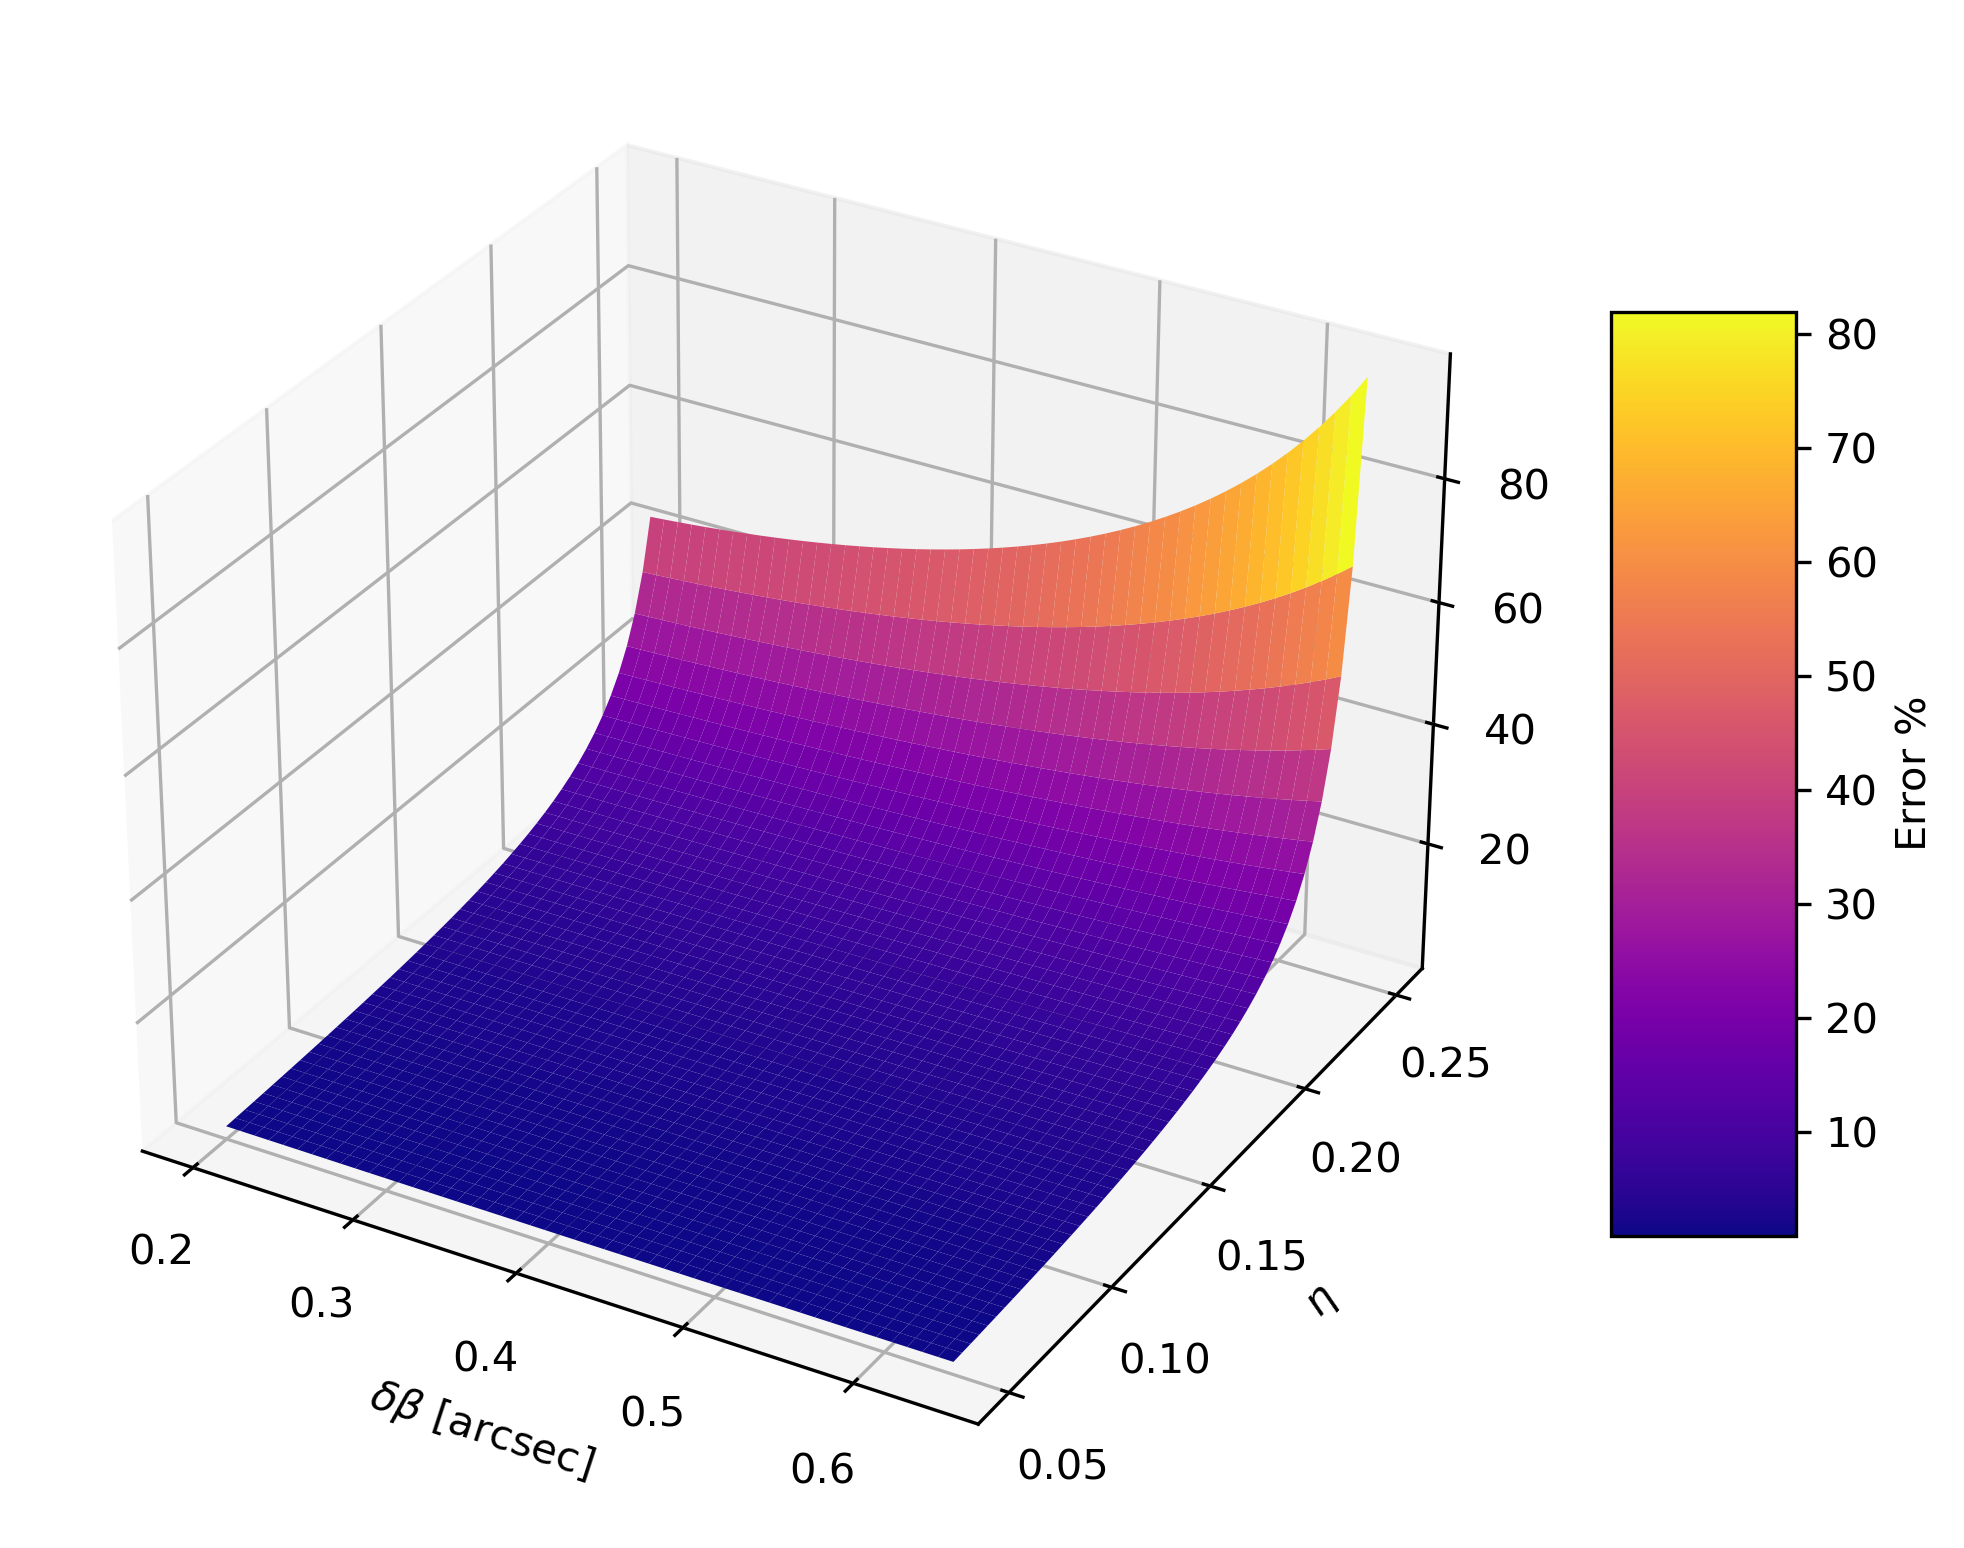

In [14]:
X, Eta = np.meshgrid(r_arr, eta_arr)
error = np.abs(mag - mag_p)/mag*100
fig = plt.figure(figsize=(8,8), dpi = 300)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Eta, error, cmap='plasma')
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
cbar.set_label('Error $\%$')
ax.set_xlabel(r'$\delta \beta$ [arcsec]') #to be constistent with our first convention (sorry for the mess)
ax.set_ylabel(r'$\eta$')
ax.set_yticks(np.arange(.05, .3, .05))
fig.savefig(my_path + 'image77.pdf', format='pdf', dpi = 300, bbox_inches='tight')
plt.show()

# Veamos el error en función de theta para $\eta = .15$

In [15]:
eta = .15
r_arr = np.linspace(.2, .67, 50)
x_arr = y_arr = r_arr*np.cos(np.pi/4)

In [16]:
mag_p = np.zeros((50,))
for x in range(50):
    sie_plasma = sieplasma(theta_E_g, eta, zl, c_light.decompose().value, Dl.decompose().value, Ds.decompose().value, Dls.decompose().value, psi0_plasma_num, theta_0_num, B, C, 0.07, x_arr[x], x_arr[x])
    R = sie_plasma.R
    mag_p[x] = R

In [17]:
mag = np.zeros((50,))
for x in range(50):
    kwargs = {'theta_E':theta_E_num.value,'eta':eta, 'A':A, 'B':B, 'C':C ,'psi0_plasma':psi0_plasma.value,\
                    'theta_0':theta_0.value}
    kwargs_lens_list = [kwargs]
    x_image, y_image, r, dt = image_position_3(x_arr[x], x_arr[x], eta)
    mag[x] = r[0]

In [18]:
error = np.abs(mag-mag_p)/mag*100

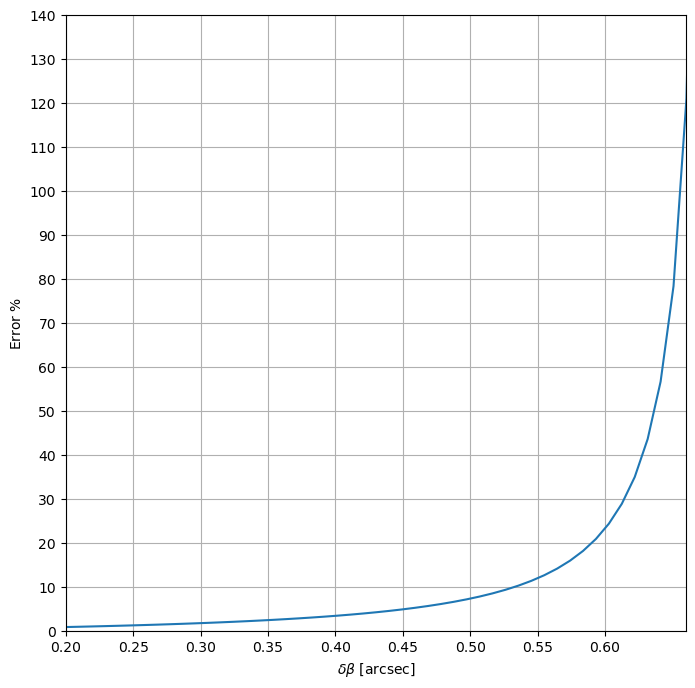

In [19]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(.2, .65, .05))
ax.set_yticks(np.arange(0, 150, 10))


plt.plot(r_arr, error ,zorder = 2)

ax.set_xlabel(r'$\delta \beta$ [arcsec]')
ax.set_ylabel('Error $\%$')
ax.set_xlim([.2, .66])
ax.set_ylim([0, 140])
plt.grid()
fig.savefig(my_path + 'image78.pdf', format='pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [20]:
eta_arr = np.linspace(.05, .3, 50)
r_arr = np.linspace(.4, .64, 50)
x_arr = y_arr = r_arr*np.cos(np.pi/4)

In [21]:
dt_p = np.zeros((50, 50))
for x in range(50):
    for i in range(50):
        sie_plasma = sieplasma(theta_E_g, eta_arr[i], zl, c_light.decompose().value, Dl.decompose().value, Ds.decompose().value, Dls.decompose().value, psi0_plasma_num, theta_0_num, B, C, 0.07, x_arr[x], x_arr[x])
        dt = sie_plasma.dt
        dt_p[x][i] = dt

In [22]:
dt = np.zeros((50, 50))
for x in range(50):
    for i in range(50):
        kwargs = {'theta_E':theta_E_num.value,'eta':eta_arr[i], 'A':A, 'B':B, 'C':C ,'psi0_plasma':psi0_plasma.value,\
                        'theta_0':theta_0.value}
        kwargs_lens_list = [kwargs]
        x_image, y_image, r, t = image_position_3(x_arr[x], x_arr[x], eta_arr[i])
        dt[x][i] = t[0]

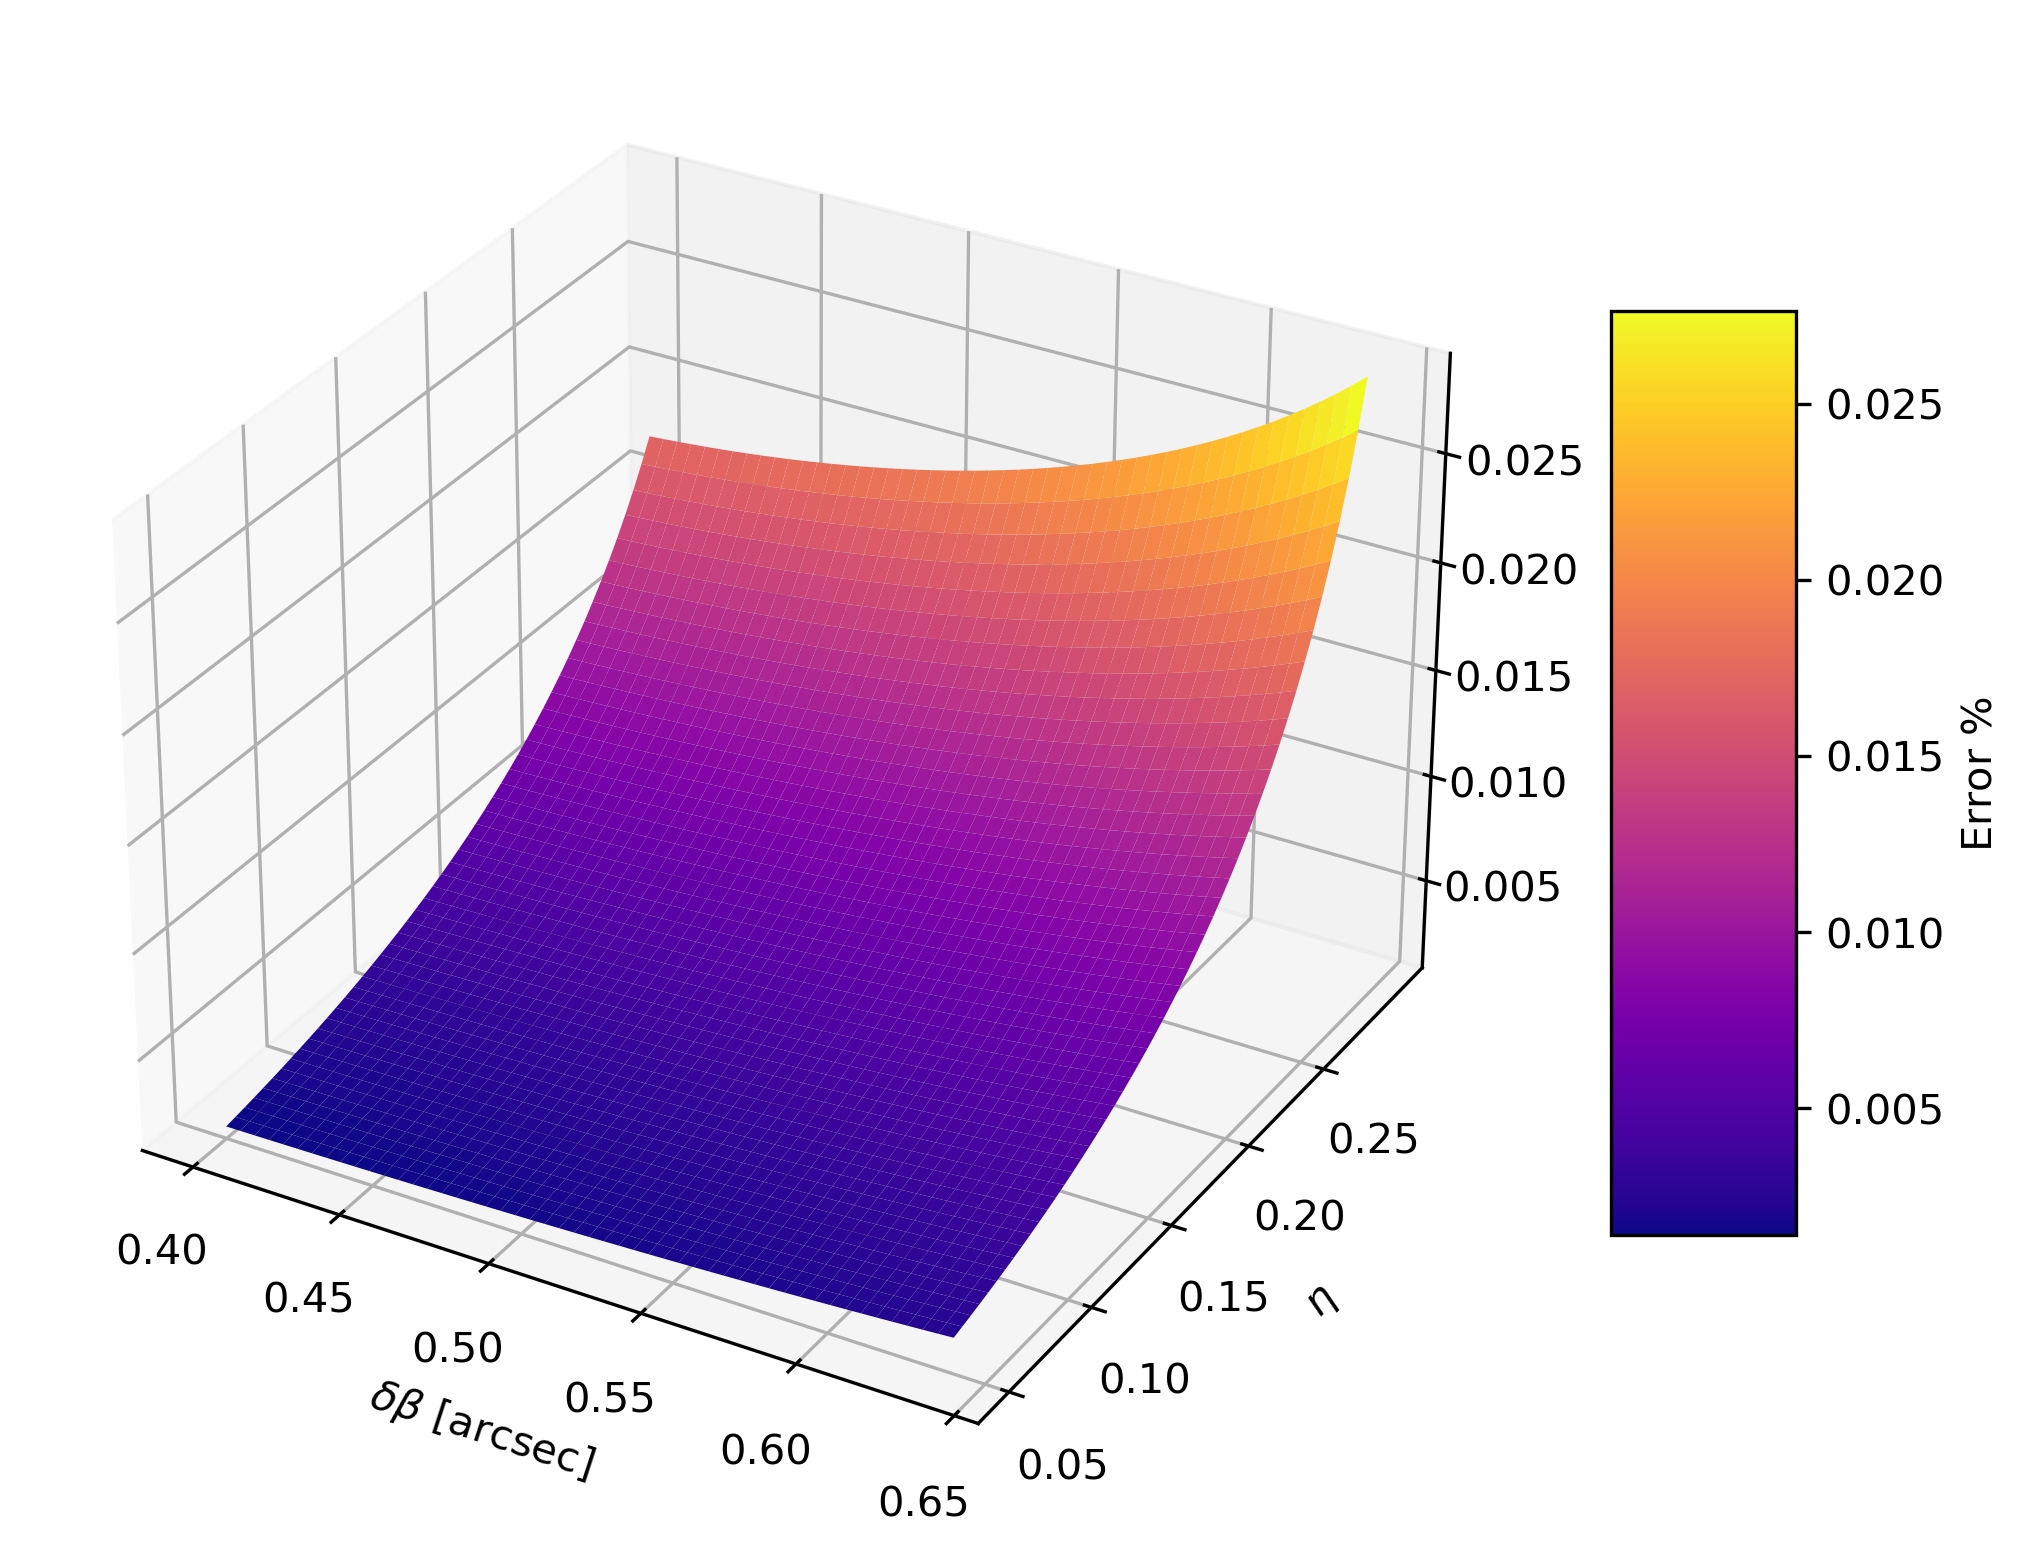

In [23]:
X, Eta = np.meshgrid(r_arr, eta_arr)
error = np.abs(dt - dt_p)/dt*100
fig = plt.figure(figsize=(8,8), dpi = 300)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Eta, error, cmap='plasma')
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
cbar.set_label('Error $\%$')
ax.set_xlabel(r'$\delta \beta$ [arcsec]') #to be constistent with our first convention (sorry for the mess)
ax.set_ylabel(r'$\eta$')
ax.set_yticks(np.arange(.05, .3, .05))
#ax.view_init(30, 130)# rotate the axes (elevation angle, azimuthal angle)
fig.savefig(my_path + 'image79.pdf', format='pdf', dpi = 300, bbox_inches='tight')
plt.show()

# Veamos el error en función de theta para $\eta = .15$

In [24]:
eta = .15
r_arr = np.linspace(.2, .67, 50)
x_arr = y_arr = r_arr*np.cos(np.pi/4)

In [25]:
dt_p = np.zeros((50,))
for x in range(50):
    sie_plasma = sieplasma(theta_E_g, eta, zl, c_light.decompose().value, Dl.decompose().value, Ds.decompose().value, Dls.decompose().value, psi0_plasma_num, theta_0_num, B, C, 0.07, x_arr[x], x_arr[x])
    dt = sie_plasma.dt
    dt_p[x] = dt

In [26]:
dt_p

array([ 9.09318635,  9.45485078,  9.81811326, 10.18287234, 10.54903461,
       10.91651411, 11.28523166, 11.65511438, 12.02609512, 12.39811203,
       12.77110813, 13.14503093, 13.51983206, 13.89546699, 14.27189468,
       14.64907734, 15.0269802 , 15.40557126, 15.78482111, 16.16470273,
       16.54519134, 16.92626423, 17.30790066, 17.69008169, 18.07279014,
       18.4560104 , 18.83972846, 19.22393174, 19.6086091 , 19.99375075,
       20.37934824, 20.76539441, 21.15188343, 21.53881074, 21.92617315,
       22.31396881, 22.70219736, 23.09085995, 23.47995947, 23.86950068,
       24.25949055, 24.6499386 , 25.04085747, 25.43226374, 25.82417906,
       26.21663209, 26.60966158, 27.00332208, 27.39769581, 27.79292304])

In [27]:
dt = np.zeros((50,))
for x in range(50):
    kwargs = {'theta_E':theta_E_num.value,'eta':eta, 'A':A, 'B':B, 'C':C ,'psi0_plasma':psi0_plasma.value,\
                    'theta_0':theta_0.value}
    kwargs_lens_list = [kwargs]
    x_image, y_image, r, t = image_position_3(x_arr[x], x_arr[x], eta)
    dt[x] = t[0]

In [28]:
error = np.abs(dt-dt_p)/dt*100

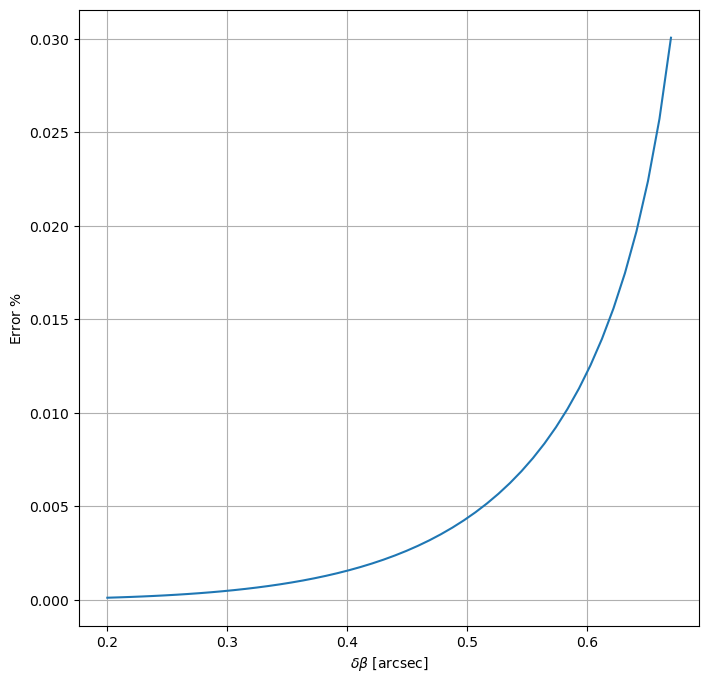

In [29]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
# ax.set_xticks(np.arange(.2, .65, .05))
# ax.set_yticks(np.arange(0, 150, 10))


plt.plot(r_arr, error ,zorder = 2)

ax.set_xlabel(r'$\delta \beta$ [arcsec]')
ax.set_ylabel('Error $\%$')
# ax.set_xlim([.2, .66])
# ax.set_ylim([0, 140])
plt.grid()
fig.savefig(my_path + 'image80.pdf', format='pdf', dpi = 300, bbox_inches='tight')
plt.show()

# A partir de este punto empieza a haber una sola imagen

In [31]:
sie_plasma.r

0.6710903313244904

In [30]:
end_total = time.time()
print('total time: ',(end_total-start_total)/60.,' minutes')

total time:  3.234934675693512  minutes
